# Chapter 10 - Relational Deep Reinforcement Learning
### Deep Reinforcement Learning *in Action*

##### Listing 10.1

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision as TV
from tqdm.notebook import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Pytorch using device:', device)

try:
    mnist_data = TV.datasets.MNIST("MNIST/", train=True, transform=None,
                                        target_transform=None, download=False) #A
    mnist_test = TV.datasets.MNIST("MNIST/", train=False, transform=None,
                                        target_transform=None, download=False) #B
except:
    mnist_data = TV.datasets.MNIST("MNIST/", train=True, transform=None,
                                        target_transform=None, download=True) #A
    mnist_test = TV.datasets.MNIST("MNIST/", train=False, transform=None,
                                        target_transform=None, download=True) #B

def add_spots(x,m=20,std=5,val=1): #C
    mask = torch.zeros(x.shape)
    N = int(m + std * np.abs(np.random.randn()))
    ids = np.random.randint(np.prod(x.shape),size=N)
    mask.view(-1)[ids] = val
    return torch.clamp(x + mask,0,1)

def prepare_images(xt,maxtrans=6,rot=5,noise=10): #D
    out = torch.zeros(xt.shape)
    for i in range(xt.shape[0]):
        img = xt[i].unsqueeze(dim=0)
        img = TV.transforms.functional.to_pil_image(img)
        rand_rot = np.random.randint(-1*rot,rot,1) if rot > 0 else 0
        xtrans,ytrans = np.random.randint(-maxtrans,maxtrans,2)
        img = TV.transforms.functional.affine(img=img, angle=int(rand_rot[0]), 
                                              translate=(xtrans,ytrans),scale=1,shear=0)
        img = TV.transforms.functional.to_tensor(img).squeeze()
        if noise > 0:
            img = add_spots(img,m=noise)
        maxval = img.view(-1).max()
        if maxval > 0:
            img = img.float() / maxval
        else:
            img = img.float()
        out[i] = img
    return out

Pytorch using device: cuda


##### Listing 10.2/10.3

In [2]:
class RelationalModule(torch.nn.Module):
    def __init__(self):
        super(RelationalModule, self).__init__()
        self.ch_in = 1
        self.conv1_ch = 16 #A
        self.conv2_ch = 20
        self.conv3_ch = 24
        self.conv4_ch = 30
        self.H = 28 #B
        self.W = 28
        self.node_size = 36 #C
        self.lin_hid = 100
        self.out_dim = 10
        self.sp_coord_dim = 2
        self.N = int(16**2) #D

        self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(4,4))
        self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(4,4))
        self.conv3 = nn.Conv2d(self.conv2_ch,self.conv3_ch,kernel_size=(4,4))
        self.conv4 = nn.Conv2d(self.conv3_ch,self.conv4_ch,kernel_size=(4,4))
        
        self.proj_shape = (self.conv4_ch+self.sp_coord_dim,self.node_size) #E
        self.k_proj = nn.Linear(*self.proj_shape)
        self.q_proj = nn.Linear(*self.proj_shape)
        self.v_proj = nn.Linear(*self.proj_shape)
        
        self.norm_shape = (self.N,self.node_size)
        self.k_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True) #F
        self.q_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)
        self.v_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)
        
        self.linear1 = nn.Linear(self.node_size, self.node_size)
        self.norm1 = nn.LayerNorm([self.N,self.node_size], elementwise_affine=False)
        self.linear2 = nn.Linear(self.node_size, self.out_dim)

    def forward(self,x):
            N, Cin, H, W = x.shape
            x = self.conv1(x) 
            x = torch.relu(x)
            x = self.conv2(x) 
            x = x.squeeze() 
            x = torch.relu(x) 
            x = self.conv3(x)
            x = torch.relu(x)
            x = self.conv4(x)
            x = torch.relu(x)

            _,_,cH,cW = x.shape
            xcoords = torch.arange(cW).repeat(cH,1).float() / cW #G
            ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float() / cH
            spatial_coords = torch.stack([xcoords,ycoords],dim=0)
            spatial_coords = spatial_coords.unsqueeze(dim=0)
            spatial_coords = spatial_coords.repeat(N,1,1,1) 
            x = torch.cat([x,spatial_coords],dim=1)
            x = x.permute(0,2,3,1)
            x = x.flatten(1,2)

            K = self.k_proj(x) #H
            K = self.k_norm(K) 

            Q = self.q_proj(x)
            Q = self.q_norm(Q) 

            V = self.v_proj(x)
            V = self.v_norm(V) 
            A = torch.einsum('bfe,bge->bfg',Q,K) #I
            A = A / np.sqrt(self.node_size)
            A = torch.nn.functional.softmax(A,dim=2) 
            with torch.no_grad():
                self.att_map = A.clone()
            E = torch.einsum('bfc,bcd->bfd',A,V) #J
            E = self.linear1(E)
            E = torch.relu(E)
            E = self.norm1(E)  
            E = E.max(dim=1)[0]
            y = self.linear2(E)  
            y = torch.nn.functional.log_softmax(y,dim=1)
            return y

##### Listing 10.4

In [3]:
agent = RelationalModule() #A
epochs = 1000
batch_size=300
lr = 1e-3
opt = torch.optim.Adam(params=agent.parameters(),lr=lr)
lossfn = nn.NLLLoss()
for i in trange(epochs):
    opt.zero_grad()
    batch_ids = np.random.randint(0,60000,size=batch_size) #B
    xt = mnist_data.data[batch_ids].detach()
    xt = prepare_images(xt,rot=30).unsqueeze(dim=1) #C
    yt = mnist_data.targets[batch_ids].detach()
    pred = agent(xt)
    pred_labels = torch.argmax(pred,dim=1) #D
    acc_ = 100.0 * (pred_labels == yt).sum() / batch_size #E
    correct = torch.zeros(batch_size,10)
    rows = torch.arange(batch_size).long()
    correct[[rows,yt.detach().long()]] = 1.
    loss = lossfn(pred,yt)
    loss.backward()
    opt.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

##### Listing 10.5

In [4]:
def test_acc(model,batch_size=500):
    acc = 0.
    batch_ids = np.random.randint(0,10000,size=batch_size)
    xt = mnist_test.data[batch_ids].detach()
    xt = prepare_images(xt,maxtrans=6,rot=30,noise=10).unsqueeze(dim=1)
    yt = mnist_test.targets[batch_ids].detach()
    preds = model(xt)
    pred_ind = torch.argmax(preds.detach(),dim=1)
    acc = (pred_ind == yt).sum().float() / batch_size
    return acc, xt, yt

acc2, xt2, yt2 = test_acc(agent)
print(acc2)

/home/jack/.cache/pypoetry/virtualenvs/reinforcement-learning-notebooks-_NpvE3mH-py3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/jack/.cache/pypoetry/virtualenvs/reinforcement-learning-notebooks-_NpvE3mH-py3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor(0.9340)


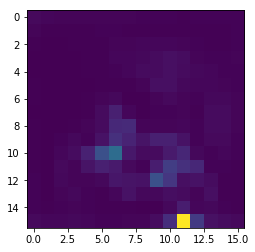

In [5]:
plt.imshow(agent.att_map[0].max(dim=0)[0].view(16,16))

##### Listing 10.6

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=(4,4)) #A
        self.conv2 = nn.Conv2d(10,16,kernel_size=(4,4))
        self.conv3 = nn.Conv2d(16,24,kernel_size=(4,4))
        self.conv4 = nn.Conv2d(24,32,kernel_size=(4,4))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2)) #B
        self.conv5 = nn.Conv2d(32,64,kernel_size=(4,4))
        self.lin1 = nn.Linear(256,128)
        self.out = nn.Linear(128,10) #C
    def forward(self,x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.conv5(x)
        x = nn.functional.relu(x)
        x = x.flatten(start_dim=1)
        x = self.lin1(x)
        x = nn.functional.relu(x)
        x = self.out(x)
        x = nn.functional.log_softmax(x,dim=1) #D
        return x

In [7]:
from einops import rearrange
x = torch.randn(5,7,7,3)
rearrange(x, "batch h w c -> batch c h w").shape

torch.Size([5, 3, 7, 7])

##### Listing 10.7

In [8]:
class MultiHeadRelationalModule(torch.nn.Module):
    def __init__(self):
        super(MultiHeadRelationalModule, self).__init__()
        self.conv1_ch = 16 
        self.conv2_ch = 20
        self.conv3_ch = 24
        self.conv4_ch = 30
        self.H = 28
        self.W = 28
        self.node_size = 64
        self.lin_hid = 100
        self.out_dim = 5
        self.ch_in = 3
        self.sp_coord_dim = 2
        self.N = int(7**2)
        self.n_heads = 3
        
        self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(1,1),padding=0) #A
        self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(1,1),padding=0)
        self.proj_shape = (self.conv2_ch+self.sp_coord_dim,self.n_heads * self.node_size)
        self.k_proj = nn.Linear(*self.proj_shape)
        self.q_proj = nn.Linear(*self.proj_shape)
        self.v_proj = nn.Linear(*self.proj_shape)

        self.k_lin = nn.Linear(self.node_size,self.N) #B
        self.q_lin = nn.Linear(self.node_size,self.N)
        self.a_lin = nn.Linear(self.N,self.N)
        
        self.node_shape = (self.n_heads, self.N,self.node_size)
        self.k_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.q_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.v_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        
        self.linear1 = nn.Linear(self.n_heads * self.node_size, self.node_size)
        self.norm1 = nn.LayerNorm([self.N,self.node_size], elementwise_affine=False)
        self.linear2 = nn.Linear(self.node_size, self.out_dim)
    
    def forward(self,x):
        N, Cin, H, W = x.shape
        x = self.conv1(x) 
        x = torch.relu(x)
        x = self.conv2(x) 
        x = torch.relu(x) 
        with torch.no_grad(): 
            self.conv_map = x.clone() #C
        _,_,cH,cW = x.shape
        xcoords = torch.arange(cW).repeat(cH,1).float() / cW
        ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float() / cH
        spatial_coords = torch.stack([xcoords,ycoords],dim=0)
        spatial_coords = spatial_coords.unsqueeze(dim=0)
        spatial_coords = spatial_coords.repeat(N,1,1,1)
        x = torch.cat([x,spatial_coords],dim=1)
        x = x.permute(0,2,3,1)
        x = x.flatten(1,2)
        
        K = rearrange(self.k_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        K = self.k_norm(K) 
        
        Q = rearrange(self.q_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        Q = self.q_norm(Q) 
        
        V = rearrange(self.v_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        V = self.v_norm(V) 
        A = torch.nn.functional.elu(self.q_lin(Q) + self.k_lin(K)) #D
        A = self.a_lin(A)
        A = torch.nn.functional.softmax(A,dim=3) 
        with torch.no_grad():
            self.att_map = A.clone() #E
        E = torch.einsum('bhfc,bhcd->bhfd',A,V) #F
        E = rearrange(E, 'b head n d -> b n (head d)')
        E = self.linear1(E)
        E = torch.relu(E)
        E = self.norm1(E)
        E = E.max(dim=1)[0]
        y = self.linear2(E)
        y = torch.nn.functional.elu(y)
        return y

##### Listing 10.8

In [9]:
import gym
from gym_minigrid.minigrid import *
from gym_minigrid.wrappers import FullyObsWrapper, ImgObsWrapper
from skimage.transform import resize

def prepare_state(x): #A
    ns = torch.from_numpy(x).float().permute(2,0,1).unsqueeze(dim=0)#
    maxv = ns.flatten().max()
    ns = ns / maxv
    return ns

def get_minibatch(replay,size): #B
    batch_ids = np.random.randint(0,len(replay),size)
    batch = [replay[x] for x in batch_ids] #list of tuples
    state_batch = torch.cat([s for (s,a,r,s2,d) in batch],)
    action_batch = torch.Tensor([a for (s,a,r,s2,d) in batch]).long()
    reward_batch = torch.Tensor([r for (s,a,r,s2,d) in batch])
    state2_batch = torch.cat([s2 for (s,a,r,s2,d) in batch],dim=0)
    done_batch = torch.Tensor([d for (s,a,r,s2,d) in batch])
    return state_batch,action_batch,reward_batch,state2_batch, done_batch

def get_qtarget_ddqn(qvals,r,df,done): #C
    targets = r + (1-done) * df * qvals
    return targets

##### Listing 10.9

In [10]:
def lossfn(pred,targets,actions): #A
    loss = torch.mean(torch.pow(\
                                targets.detach() -\
                                pred.gather(dim=1,index=actions.unsqueeze(dim=1)).squeeze()\
                                ,2),dim=0)
    return loss
  
def update_replay(replay,exp,replay_size): #B
    r = exp[2]
    N = 1
    if r > 0:
        N = 50
    for i in range(N):
        replay.append(exp)
    return replay

action_map = { #C
    0:0, 
    1:1,
    2:2,
    3:3,
    4:5,
}


##### Listing 10.10

In [11]:
from collections import deque
env = ImgObsWrapper(gym.make('MiniGrid-DoorKey-5x5-v0')) #A
state = prepare_state(env.reset()) 
GWagent = MultiHeadRelationalModule() #B
Tnet = MultiHeadRelationalModule() #C
maxsteps = 400 #D
env.max_steps = maxsteps
env.env.max_steps = maxsteps

epochs = 50000
replay_size = 9000
batch_size = 50
lr = 0.0005
gamma = 0.99
replay = deque(maxlen=replay_size) #E
opt = torch.optim.Adam(params=GWagent.parameters(),lr=lr)
eps = 0.5
update_freq = 100
for i in trange(epochs):
    pred = GWagent(state)
    action = int(torch.argmax(pred).detach().numpy())
    if np.random.rand() < eps: #F
        action = int(torch.randint(0,5,size=(1,)).squeeze())
    action_d = action_map[action]
    state2, reward, done, info = env.step(action_d)
    reward = -0.01 if reward == 0 else reward #G
    state2 = prepare_state(state2)
    exp = (state,action,reward,state2,done)
    
    replay = update_replay(replay,exp,replay_size)
    if done:
        state = prepare_state(env.reset())
    else:
        state = state2
    if len(replay) > batch_size:
        
        opt.zero_grad()
        
        state_batch,action_batch,reward_batch,state2_batch,done_batch = get_minibatch(replay,batch_size)
        
        q_pred = GWagent(state_batch).cpu()
        astar = torch.argmax(q_pred,dim=1)
        qs = Tnet(state2_batch).gather(dim=1,index=astar.unsqueeze(dim=1)).squeeze()
        
        targets = get_qtarget_ddqn(qs.detach(),reward_batch.detach(),gamma,done_batch)
        
        loss = lossfn(q_pred,targets.detach(),action_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(GWagent.parameters(), max_norm=1.0) #H
        opt.step()
    if i % update_freq == 0: #I
        Tnet.load_state_dict(GWagent.state_dict())

  0%|          | 0/50000 [00:00<?, ?it/s]

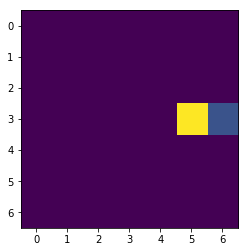

In [12]:
state_ = env.reset()
state = prepare_state(state_)
GWagent(state)
plt.imshow(env.render('rgb_array'))
plt.imshow(state[0].permute(1,2,0).detach().numpy())
head, node = 2, 26
plt.imshow(GWagent.att_map[0][head][node].view(7,7))